# Void-Dislocation Interaction Test Case

Based on the analytical solution provided by Gavazza & Barnett (1974), and the implementation in Takahashi and Ghoniem (2008), we have the testcase as following:

* The solution of the stress:
$$
\tau_{yz}(t,0,z)=
\sum_{n=1}^\infty\left\{-a^{n+1}(2\mu_1\alpha_n+\mu_1\beta_n)+6\mu_1K_n\Omega_n\frac{2n+1}{2n+5}\right\}
    {1\over r^{n+2}}P^{n-1}_{n+1}
$$

$$ +
\sum_{n=1}^\infty\left\{-{1\over2}\mu_1a^{n+1}\beta_n+\mu_1K_n\Omega_n\frac{2n+3}{2n+5}\right\}
    {1\over r^{n+2}}P^{n+1}_{n+1}
$$

$$ +
\sum_{n=1}^\infty\left\{2\mu_1\left({a^2\over r^2}-1\right)K_n\Omega_n+\mu_1K_n\Omega_n\frac{2}{2n+5}\right\}
    {1\over r^{n+2}}P^{n+1}_{n+3}
$$

$$ +
\sum_{n=1}^\infty\left\{24\mu_1\left({a^2\over r^2}-1\right)K_n\Omega_n+\mu_1K_n\Omega_n\frac{24}{2n+5}\right\}
    {1\over r^{n+2}}P^{n-1}_{n+3}
$$

where,
$$
K_n=-\frac{\lambda_1 + \mu_1}{2[(n+2)\lambda_1+(3n+5)\mu_1]}
$$

$$
\Omega_n=\frac{2\eta_n(\mu_1-\mu_2)a^{2n+1}/t^n}{\mu_1[(n+2)+E_n^I(2n+1)(n+1)]+\mu_2(2n)}
$$

$$
\alpha_n=\frac{(\mu_1-\mu_2)\eta_n}{\mu_1(n+2)+\mu_2(n-1)}
\frac{\mu_1\{(n+2)-E_n^I(2n+1)(n-1)\}}{\mu_1{(n+2)+E_n^I(2n+1)(n+1)}+\mu_2(2n)}
\left({a\over t}\right)^n
$$

$$
\beta_n=\frac{(\mu_2-\mu_1)\eta_n}{\mu_1(n+2)+\mu_2(n-1)}
\frac{\mu_1\{(n+2)+E_n^I(2n+1)(n-1)\}+2\mu_2(n-1)}{\mu_1{(n+2)+E_n^I(2n+1)(n+1)}+\mu_2(2n)}
\left({a\over t}\right)^n
$$

$$
\eta_n=\left(b\over4\pi\right)\frac{(-1)^n2^n(n-1)!}{(2n-1)!}
$$

$$
E_n^I=\frac{1}{2n+1}\frac{(n-1)\lambda_1-(n+4)\mu_1}{(n+2)\lambda_1+(3n+5)\mu_1}
$$

$P_l^m$ is the *unnormalized Legendre Polynomial* with *Condon-Shortley Phase* coefficients.

In [1]:
import numpy as np
from scipy.misc import factorial
from scipy.io import loadmat
import pyshtools
import matplotlib.pyplot as plt

def Legendre_poly(N, Z, LegendreP,dl,dm, csphase=-1):
    nmax = N.max()
    dl = np.array(dl)
    dm = np.array(dm)
    p = np.empty(Z.shape+dl.shape)
    #print(p.shape)
    for idx, _ in np.ndenumerate(N):
        #print(idx)
        n, z = (N[idx], Z[idx])
        Pvalue = LegendreP(nmax+3, z, csphase=csphase)
        l = n + dl; m = n + dm;
        Pidx = np.array((l*(l+1)/2+m), dtype=np.int)
        #print(p[idx].shape)
        #print(Pidx)
        p[idx] = Pvalue[Pidx]

    return p

def void_screw_disl(nmax, zs, ts, mu1, mu2, nu1=0.25, nu2=0.25, a=1, b=1):
    ns = np.arange(nmax) + 1
    n, z, t = np.meshgrid(ns, zs, ts)
    r = np.sqrt(z**2 + t**2)
    z = z/r
    lambda1 = 2*mu1*nu1/(1-2*nu1)
    lambda2 = 2*mu2*nu2/(1-2*nu2)

    Kn = -(lambda1+mu1)/2/((n+2)*lambda1+(3*n+5)*mu1)
    #EnI = ((n-1)*lambda1 - (n+4)*mu1)/((n+2)*(2*n+1)*lambda1+(3*n+5)*mu1)
    EnI = 1/(2*n+1)*((n-1)*lambda1 - (n+4)*mu1)/((n+2)*lambda1+(3*n+5)*mu1)
    #EnI = 1/(2*n+1)*((n+2)*lambda1 - (n-3)*mu1)/((n-1)*lambda1+(3*n-2)*mu1)
    #EnI = ((n+2)*lambda1 - (n-3)*mu1)/((2*n+1)*(n-1)*lambda1+(3*n-2)*mu1)
    eta_n = b/4/np.pi * ((-2)**n) *factorial(n-1)/factorial(2*n-1)
    #print('Kn', Kn.shape)
    #print('EnI', EnI.shape)
    #print('eta_n', eta_n.shape)
    #print('Kn', Kn)
    #print('EnI', EnI)
    #print('eta_n', eta_n)

    Cab = (mu1-mu2)*eta_n/(mu1*(n+2)+mu2*(n-1))
    denom_ab = mu1*((n+2) + EnI*(2*n+1)*(n+1)) + mu2*2*n
    a_t_n = (a/t)**n
    alpha_n = Cab/denom_ab * (mu1*((n+2) - EnI*(2*n+1)*(n-1))) * a_t_n
    beta_n = -Cab/denom_ab * (mu1*((n+2) + EnI*(2*n+1)*(n-1)) + 2*mu2*(n-1)) * a_t_n
    #print('alpha_n', alpha_n.shape)
    #print('beta_n', beta_n.shape)
    #print('alpha_n', alpha_n)
    #print('beta_n', beta_n)

    Omega_n = 2*eta_n*(mu1-mu2)* a_t_n * (a**(n+1)) / denom_ab
    #print('Omega_n', Omega_n.shape)
    #print('Omega_n', Omega_n)

    C_term1 = (-a**(n+1) * (2*mu1*alpha_n + mu1*beta_n) + 6*mu1*Kn*Omega_n*(2*n+1)/(2*n+5)) /r**(n+2)
    C_term2 = (-a**(n+1)/2 *mu1*beta_n + mu1*Kn*Omega_n*(2*n+3)/(2*n+5)) /r**(n+2)
    C_term3 = (2*mu1*(a**2/r**2 - 1)*Kn*Omega_n+mu1*Kn*Omega_n*2/(2*n+5)) /r**(n+2)
    C_term4 = (24*mu1*(a**2/r**2 - 1)*Kn*Omega_n+mu1*Kn*Omega_n*24/(2*n+5)) /r**(n+2)
    #C_term3 = (2*mu1*(0 - 1)*Kn*Omega_n+mu1*Kn*Omega_n*2/(2*n+5)) /r**(n+2)
    #C_term4 = (24*mu1*(0 - 1)*Kn*Omega_n+mu1*Kn*Omega_n*24/(2*n+5)) /r**(n+2)
    #print(C_term1.shape, C_term2.shape, C_term3.shape, C_term4.shape)
    #print(C_term1, C_term2, C_term3, C_term4)

    # After experiment, the implementation in Takahashi&Ghoniem(2008) is unnormalized Legendre Polynomial
    p = Legendre_poly(n, z, pyshtools.legendre.PLegendreA,dl = np.array([1, 1, 3, 3]),dm = np.array([-1,1, 1,-1]), csphase=-1)
    #C3 = 2*mu1*a**2*Kn*Omega_n
    #C4 = 24*mu1*a**2*Kn*Omega_n
    #print(Kn, Omega_n, (C3+C4))
    return np.sum(C_term1*p[:,:,:,0] + C_term2*p[:,:,:,1] + C_term3*p[:,:,:,2] + C_term4*p[:,:,:,3], axis=1)

[[ -1.83475557e-03  -1.30113965e-03  -9.45553837e-04  -7.09185252e-04
   -5.51454440e-04  -4.41503672e-04  -3.58698915e-04  -2.89870771e-04
   -2.39341981e-04  -2.02935187e-04  -1.66904943e-04  -1.06633838e-04
   -6.71862441e-05  -3.92569871e-05  -2.21224822e-05  -1.36125393e-05
   -9.31759425e-06  -6.18232821e-06  -4.27951366e-06  -4.08127499e-06]]
[[ 13.53035958  13.60536058  13.88286301  14.04797122  14.20001058
   13.84274326  13.87702846  14.09186746  14.34265243  13.53233626
   13.99206238  13.55994334  13.42053031  13.5427718   16.73408771
   17.84445382  23.35057123  14.68682461  23.7429193   33.68929584]]


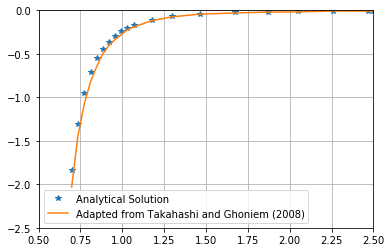

In [2]:
#### Takahashi & Ghoniem (2010) ####
mu1 = 81.8
mu2 = 54.6
nu1 = 0.3
nu2 = 0.25
a = 1.25
b = 0.248

tau_test = loadmat('test_screw/test_takahashi.mat')['Data001']

nmax = 100
zs = np.array([0, ])
ts = tau_test[:, 0]*a*2 #np.linspace(a+2*b, 5*a, 20)

tau_yz = void_screw_disl(nmax, zs, ts, mu1, mu2, nu1, nu2, a, b)

print(tau_yz/mu1)
print(tau_test[:,1]/tau_yz)

plt.plot(ts/a/2, tau_yz.T/mu1*1000, '*')
plt.plot(tau_test[:,0], tau_test[:,1])
plt.xlim(0.5,2.5)
plt.ylim(-2.5, 0)
plt.grid(True)
plt.legend(['Analytical Solution', 'Adapted from Takahashi and Ghoniem (2008)'])
#plt.savefig('SHanalytical.png', transparent=True)
plt.show()

### Long range Esitimation

The long range esitimation given by Gavazza&Barnett(1974):

$$
f_x^\infty(t,0,z)=\frac{5\gamma b^2\mu_1a^3}{2\pi t}{1\over r^3}\left(1-2\nu_1+3\nu_1\frac{z^2}{r^2}\right)
$$

where 
$$
\gamma=\frac{\Gamma-1}{2\Gamma(4-5\nu_1)+7-5\nu_1},\quad \Gamma={\mu_2\over\mu_1}
$$

[[-0.34746184 -0.34746184 -0.34746184 -0.34746184 -0.34746184 -0.34746184
  -0.34746184 -0.34746184 -0.34746184 -0.34746184 -0.34746184 -0.34746184
  -0.34746184 -0.34746184 -0.34746184 -0.34746184 -0.34746184 -0.34746184
  -0.34746184 -0.34746184 -0.34746184 -0.34746184 -0.34746184 -0.34746184
  -0.34746184 -0.34746184 -0.34746184 -0.34746184 -0.34746184 -0.34746184]]


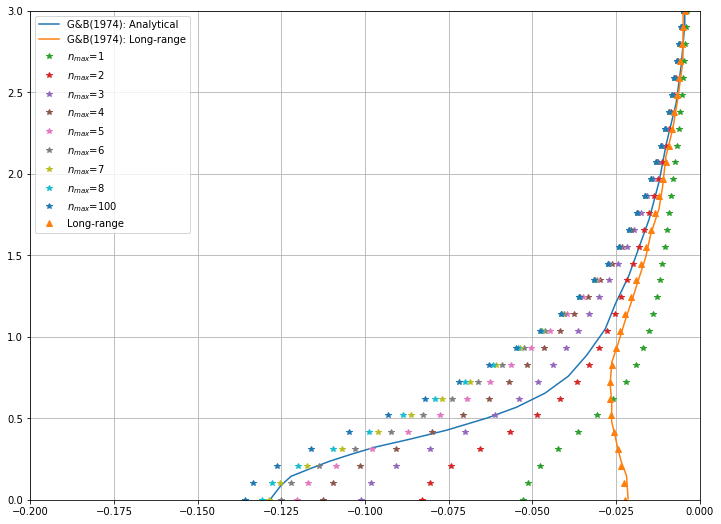

In [3]:
#### Gavazza & Barnett (1974) ####
mu1 = 2.65
mu2 = 0
nu1 = 0.347
nu2 = 0.25
a = 1
b = 1

## Analytical Solution
nlist = list(range(1, 9))+[100,]
zs = np.linspace(0, 3, 30)
ts = [1.2, ]
tau_test_data = loadmat('test_screw/Gavazza_t'+str(ts[0])+'.mat')
#print(tau_test_data.keys())
x_offset = 0.002; x_scale = 1
G0_A = tau_test_data['G0_A']
G0_E = tau_test_data['G0_E']
#G6_A = tau_test_data['G6_A']
#G6_E = tau_test_data['G6_E']
G0_A[:, 0] = (G0_A[:, 0]+x_offset)/x_scale
G0_E[:, 0] = (G0_E[:, 0]+x_offset)/x_scale
#G6_A[:, 0] = (G6_A[:, 0]+x_offset)/x_scale
#G6_E[:, 0] = (G6_E[:, 0]+x_offset)/x_scale

plt.figure(figsize=(12,9))
plt.plot(G0_A[:,0], G0_A[:,1])
plt.plot(G0_E[:,0], G0_E[:,1])
#plt.plot(G6_A[:,0], G6_A[:,1])
#plt.plot(G6_E[:,0], G6_E[:,1])
for nmax in nlist:
    #nmax = 100
    tau_yz = void_screw_disl(nmax, zs, ts, mu1, mu2, nu1, nu2, a, b)
    #print(tau_yz.shape)
    #print(tau_yz.T)
    #print(tau_test[:,1]/tau_yz)
    normed_tau = tau_yz*a/mu1/b
    plt.plot(normed_tau, zs/a, '*')

## Long-range Esitimation
Gamma = mu2/mu1
gamma = (Gamma-1)/(2*Gamma*(4-5*nu1)+7-5*nu1)
z, t = np.meshgrid(zs, ts)
r = np.sqrt(z**2+t**2)
fx_inf = (5*gamma*b**2*mu1*a**3/2/np.pi/t)/r**3 * (1-2*nu1+3*nu1*z**2/r**2)
#print(fx_inf.shape)
print((5*gamma*b**2*mu1*a**3/2/np.pi/t)*3*nu1)
plt.plot(fx_inf.flatten()*a/mu1/b**2, zs/a, '^')

## Setup the plot
#plt.gca().set_xlim(right=0)
plt.xlim(-0.2*(10**(np.ceil(np.log10(-normed_tau.min()*2)))), 0)
#plt.xlim(0, 0.2*(10**(np.ceil(np.log10(normed_tau.max()*2)))))
plt.ylim(zs[0], zs[-1])
plt.grid(True)
plt.legend(['G&B(1974): Analytical', 'G&B(1974): Long-range']+['$n_{max}$='+str(i) for i in nlist]+['Long-range', ])
#plt.legend(['Analytical Solution', 'Adapted from Gavazza&Barnett(1974)'])
#plt.savefig('SHanalytical_Gavazza.png', transparent=True)
plt.show()

### Analytical solution implementation by Willis et al. (1972)

The void-dislocation interaction energy is given:

$$
E = -\frac{\mu b^2a}{4\pi}\sum_{n=1}^\infty \left({2a\over d}\right)^{2n}\frac{(n-1)!n!}{(2n+1)!}
    \left[1+\frac{(n+1)+2mn}{n+2}\right]
$$

where $m = (6-n)/(3n^2+7n+6)$

(79, 50) (79, 50)
(79, 50) (50,)


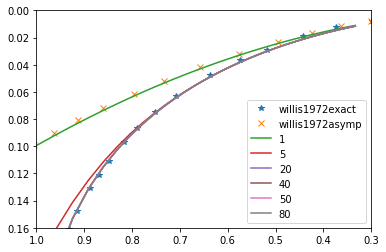

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import factorial
from scipy.io import loadmat

#a_d = np.linspace(0.3, 1.0)
d = np.linspace(1.0, 3.0)
a = 1
a_d = a/d
n = np.arange(1, 80)

A, N = np.meshgrid(a_d, n)
print(A.shape, N.shape)

M = (6-N)/(3*N**2+7*N+6)
fact = factorial(N-1)*factorial(N)/factorial(2*N+1)
#print(fact)
E = 1/4/np.pi*(2*A)**(2*N)*fact*(1+(N+1+2*M*N)/(N+2))
Ep= np.gradient(np.sum(E[:n.max()+1,:],axis=0), d)

print(E.shape, Ep.shape)

#print(E)
exactE = loadmat('Willis1972fig2.mat')['exactE']
asympE = loadmat('Willis1972fig2.mat')['asympE']
plt.plot(exactE[:,0], exactE[:,1], '*')
plt.plot(asympE[:,0], asympE[:,1], 'x')
nlist = [1, 5, 20, 40, 50, 80]
for nn in nlist:
    plt.plot(a_d, np.sum(E[:nn,:],axis=0))
plt.xlim(1.0, 0.3)
plt.ylim(0.16, 0)
plt.legend(['willis1972exact', 'willis1972asymp']+nlist)
plt.show()
#plt.plot(d, Ep)

The force term is:

$$
F_1 = {\mu b^2\over2\pi a}\sum_{n=1}^\infty\frac{(-1)^n2^nn!}{(2n)!}\left(a^2\over rd\right)^nz
    \left\{P_{n+1}^{n-1}(\cos\theta)\left(\frac{1+(2n-1)m}{n+2}\right)
          -\frac{1+m}{2(n+2)}P_{n+1}^{n+1}(\cos\theta)
          +{3\over l}cos\theta(P_{n+2}^{n+1}(\cos\theta)+P_{n+2}^{n-1}(\cos\theta))
          -{6\over l}(1-z)(P_{n+3}^{n+1}(\cos\theta)+12P_{n+3}^{n-1}(\cos\theta))
    \right\}
$$

where $z=(a/r)^2$ and $l=2(3n^2+7n+6)$

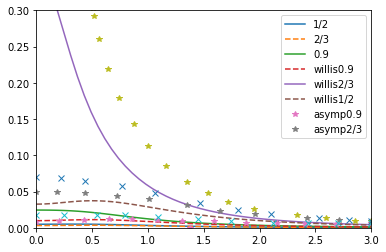

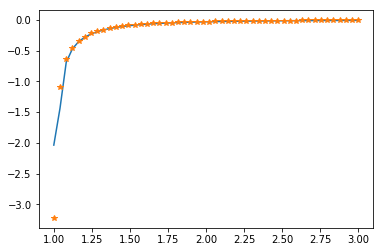

In [5]:
def willis1972(a, d, nmax, x3):
    n = np.arange(1, nmax)
    r = np.sqrt(x3**2+d**2)
    ct= x3/r
    st= d/r
    N, X3 = np.meshgrid(n, x3)

    M = (6-N)/(3*N**2+7*N+6)
    R = np.sqrt(X3**2+d**2)
    CT= X3/R
    L = 2*(3*N**2+7*N+6)
    Z = (a/R)**2

    p = Legendre_poly(N, CT, pyshtools.legendre.PLegendreA, dl=[1, 1, 2, 2, 3, 3], dm=[-1, 1, 1, -1, 1, -1], csphase=-1)
    #print(p.shape)

    prefactor = 1/2/np.pi*(-2*a**2/R/d)**N*factorial(N)/factorial(2*N) * Z
    term1 = (1+(2*N-1)*M)/(N+2)*p[:,:,0]
    term2 = -(1+M)/2/(N+2)*p[:,:,1]
    term3 = 3/L*CT*(p[:,:,2]+6*p[:,:,3])
    term4 = -6/L*(1-Z)*(p[:,:,4]+12*p[:,:,5])

    F1 = prefactor*(term1+term2+term3+term4)
    #print(F1.shape)
    Fa = 5.0/32/np.pi*(a/d)**4*(1+3*ct**2)*st**3
    #tau_yz = -void_screw_disl(49, x3, [d,], 1, 0, 1.0/3, 1.0/3, a, 1)
    F = -2*np.trapz(np.sum(F1[:, :], axis=1), x=x3)
    #print(F)
    
    return (F1, Fa, F)

plt.figure()
a = 1
adlist = [0.5, 2/3, 0.9]
for a_d in adlist:
    d = a/a_d
    nmax = 50
    x3 = np.linspace(0, 3)*d
    F1, Fa, F = willis1972(a, d, nmax, x3)
    #plt.plot([d, ], [F, ], '*')

    #nlist = [1, 5, 10, 20, 40, 50]
    #for nn in nlist:
    plt.plot(x3/d, np.sum(F1[:, :], axis=1))
    plt.plot(x3/d, Fa, '--')
    #print(tau_yz)
    #plt.plot(x3/d, tau_yz, ':')

F09 = loadmat('Willis1972fig3.mat')['exact09']
F23 = loadmat('Willis1972fig3.mat')['exact23']
F12 = loadmat('Willis1972fig3.mat')['exact12']
Fa09= loadmat('Willis1972fig3.mat')['asymp09']
Fa23= loadmat('Willis1972fig3.mat')['asymp23']
plt.plot(F12[:,0], F12[:,1], '*')
plt.plot(F23[:,0], F23[:,1], '*')
plt.plot(F09[:,0], F09[:,1], '*')
plt.plot(Fa23[:,0],Fa23[:,1],'x')
plt.plot(Fa09[:,0],Fa09[:,1],'x')
plt.legend(['1/2','2/3','0.9', 'willis0.9', 'willis2/3', 'willis1/2', 'asymp0.9', 'asymp2/3'])
plt.xlim(0,3)
plt.ylim(0,.3)

plt.figure()
dlist = np.linspace(1, 3)
a = 1
Flist = []
plt.plot(dlist, Ep)
for d in dlist:
    nmax = 50
    x3 = np.linspace(0, 5)
    F1, Fa, F = willis1972(a, d, nmax, x3)
    Flist.append(F)

plt.plot(dlist, Flist, '*')
plt.show()

## Implementation of ShElastic Solution

First we import the libraries we developed:

In [6]:
import numpy as np
import pyshtools
from SHUtil import SHCilmToVector
from SHBV import spec_J2lmk, spec_lmk2J, subCmat, print_SH_mode, create_Cmat, visualize_Cmat, stress_solution
from ShElastic import T_mode, S_mode

Then we generate the meshgrid on the void surface for boundary conditions. 

In [7]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

#### Gavazza & Barnett (1974) ####
mu = 2.65
nu = 0.347
a = 1
b = 1
t = ts[0]

#### Willis, Hayns & Bullough (1972) ####
mu = 1
nu = 1.0/3
a = 1
b = 1
t = 1.0/0.9

x3 = np.linspace(0, 3, 30)

# zs = np.linspace(0,6,50)
# ts = [t, ]

lmax_full = 45
lmax_mode = 40
Cmat_file = 'Cmat_lmax%d_mode%d_mu%f_nu%f.mat' % (lmax_full, lmax_mode, mu, nu)

Ngrid = 46
theta = np.arange(0, np.pi, np.pi/Ngrid)
phi = np.arange(0, 2*np.pi, np.pi/Ngrid)
THETA, PHI = np.meshgrid(theta, phi)
print(THETA.shape, PHI.shape)

Z = a*np.cos(THETA)
Y = a*np.sin(THETA)*np.sin(PHI)
X = a*np.sin(THETA)*np.cos(PHI)
#print(Z)

N = -np.stack([X/a, Y/a, Z/a], axis=-1)
print(N.shape)

(92, 46) (92, 46)
(92, 46, 3)


Then we evaluate traction boundary conditions on the spherical surface. We have a spherical void center at the origin with radius $a$, and a RH screw dislocation at $(t,0,0)$, with $\hat{\xi}=\hat{\mathbf{e}}_z$, with a burger's vector magnitude of $b$. The stress field induced by the dislocation in an infinite medium can be written as $\mathbf{\sigma}^\infty$, with the only two non-zero terms:

$$
\sigma_{xz}^\infty = -\frac{\mu b}{2\pi}\frac{y}{(x-t)^2+y^2} \\
\sigma_{yz}^\infty = \frac{\mu b}{2\pi}\frac{x-t}{(x-t)^2+y^2}
$$

(92, 46, 3, 3)
(92, 46, 3)


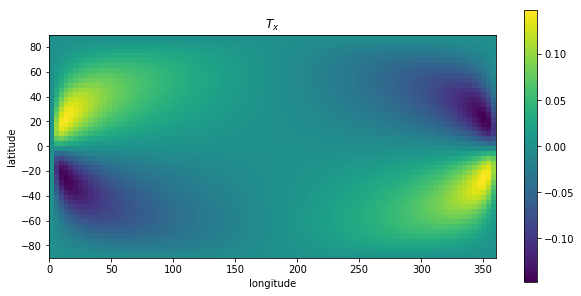

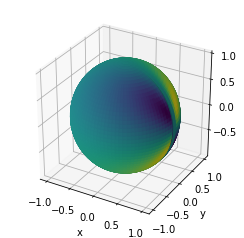

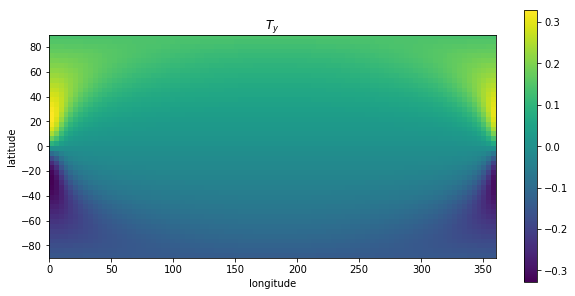

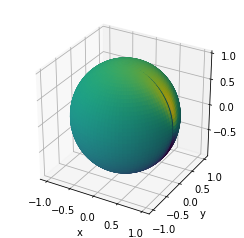

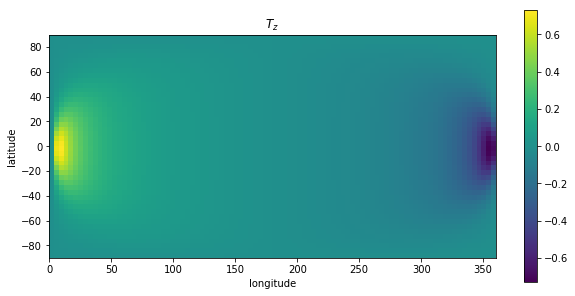

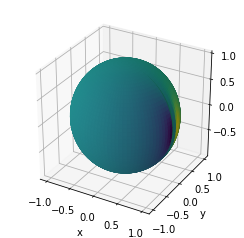

In [8]:
sigma_inf = np.zeros(THETA.shape+(3, 3))
sigma_inf[:, :, 0, 2] = -mu*b/2/np.pi * Y/((X-t)**2+Y**2)
sigma_inf[:, :, 2, 0] = -mu*b/2/np.pi * Y/((X-t)**2+Y**2)
sigma_inf[:, :, 1, 2] =  mu*b/2/np.pi * (X-t)/((X-t)**2+Y**2)
sigma_inf[:, :, 2, 1] =  mu*b/2/np.pi * (X-t)/((X-t)**2+Y**2)

print(sigma_inf.shape)

T_inf = N*0
for i,x in np.ndenumerate(THETA):
    T_inf[i] = np.dot(sigma_inf[i], N[i])

T_usr_mesh = T_inf
print(T_usr_mesh.shape)

ttl = ['$T_x$','$T_y$','$T_z$']
for i in range(3):
    fv = T_usr_mesh[:,:,i]
    fmax, fmin = fv.max(), fv.min()
    fcolors = (fv - fmin)/(fmax - fmin)    # normalize the values into range [0, 1]
    fig0 = plt.figure(i*2, figsize=(10, 5))
    ax0 = fig0.add_subplot(111)
    cax0 = ax0.imshow(fv.T, extent=(0, 360, -90, 90), cmap='viridis')
    ax0.set(xlabel='longitude', ylabel='latitude', title=ttl[i])
    fig0.colorbar(cax0)
    fig1 = plt.figure(i*2+1, figsize=plt.figaspect(1.))  # make the axis with equal aspects
    ax1= fig1.add_subplot(111, projection='3d')   # add an subplot object with 3D plot
    ax1.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=cm.viridis(fcolors))
    ax1.set(xlabel='x', ylabel='y', zlabel='z')
plt.show()


Then we expand the traction boundary conditions to spherical harmonic modes:

lmax = 22 mode_max = 19


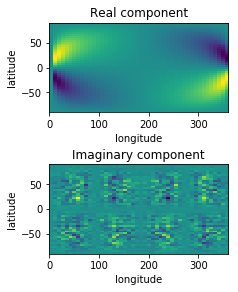

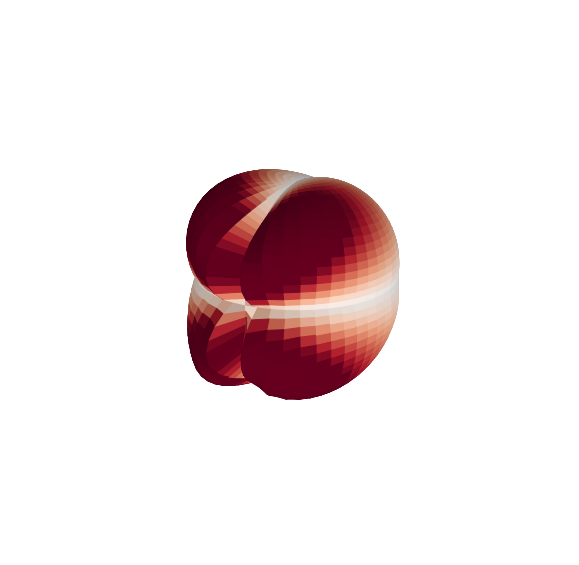

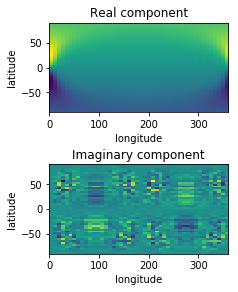

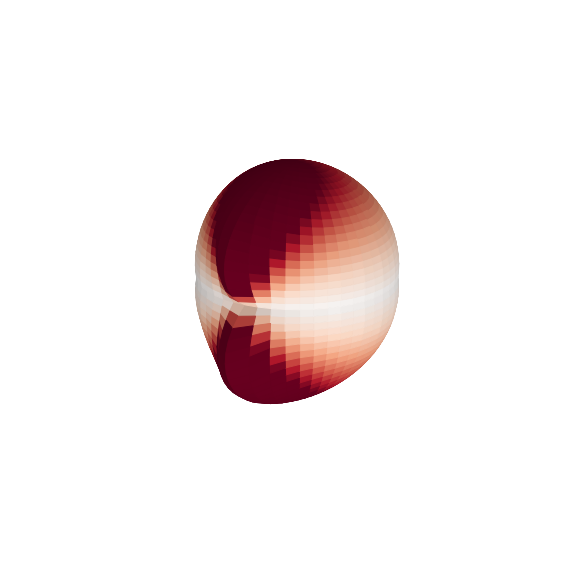

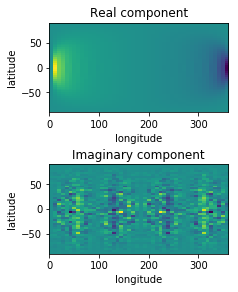

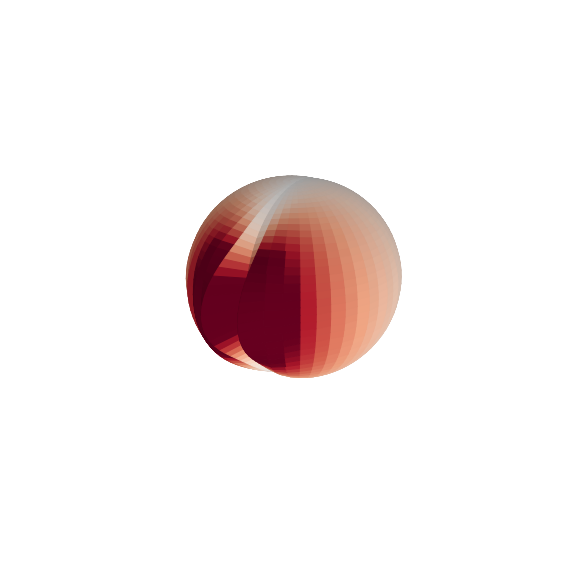

In [9]:
T_usr_vec = np.array([])
lmax_sub = np.int(Ngrid/2) - 1
mode_sub = lmax_sub - 3
print('lmax =', lmax_sub, 'mode_max =', mode_sub)
np.set_printoptions(suppress=True)

mk = '*x.'
for k in range(3):
    T_usr_cilm = pyshtools.expand.SHExpandDHC(T_usr_mesh[:,:,k].T, sampling=2, lmax_calc=lmax_sub)
    T_usr_mode = pyshtools.SHCoeffs.from_array(T_usr_cilm)
    T_usr_grid = T_usr_mode.expand()
    fig1, ax1 = T_usr_grid.plot()
    fig2, ax2 = T_usr_grid.plot3d(elevation=20, azimuth=30)
    fig1.suptitle('k=%d'%k)
    fig2.suptitle('k=%d'%k)
    #power_per_l = pyshtools.spectralanalysis.spectrum(T_usr_cilm)
    #plt.loglog(np.arange(2, T_usr_cilm.shape[1]), power_per_l[2:], mk[k])
    # print(T_usr_cilm.shape)
    # T_usr_vec_p = SHCilmToVector(T_usr_cilm, lmax = lmax_sub)
    # print(T_usr_vec_p.shape)
    T_usr_vec = np.hstack((T_usr_vec, SHCilmToVector(T_usr_cilm, lmax = lmax_sub)))
#T_usr_idx = print_SH_mode(T_usr_vec,m_dir=3)
#plt.grid(True)
#plt.xlabel('degree l')
#plt.ylabel('the power of degree l')
#plt.legend(['$T_x$','$T_y$','$T_z$'])
#plt.show()

In [10]:
import scipy.sparse as spm
from scipy.io import loadmat, savemat

m_max = 3
Cmat = create_Cmat(lmax_full, lmax_mode, mu, nu, m_max=m_max, Cmat_file=Cmat_file, recalc=False, etol=1e-10)
#Cmat = loadmat(Cmat_file)['Cmat']
#print(Cmat_file, Cmat.shape, lmax_full, lmax_mode, lmax_sub, mode_sub)
#savemat(Cmat_file, {'Cmat': Cmat})

In [11]:
Csub = subCmat(Cmat, lmax_full, lmax_mode, lmax_sub, mode_sub, m_max=m_max)
#savemat(Cmat_file, {'Cmat': Cmat})

0 0 0
0 1 -1
0 1 0
0 1 1
0 2 -2
0 2 -1
0 2 0
0 2 1
0 2 2
0 3 -3
0 3 -2
0 3 -1
0 3 0
0 3 1
0 3 2
0 3 3
0 4 -4
0 4 -3
0 4 -2
0 4 -1
0 4 0
0 4 1
0 4 2
0 4 3
0 4 4
0 5 -5
0 5 -4
0 5 -3
0 5 -2
0 5 -1
0 5 0
0 5 1
0 5 2
0 5 3
0 5 4
0 5 5
0 6 -6
0 6 -5
0 6 -4
0 6 -3
0 6 -2
0 6 -1
0 6 0
0 6 1
0 6 2
0 6 3
0 6 4
0 6 5
0 6 6
0 7 -7
0 7 -6
0 7 -5
0 7 -4
0 7 -3
0 7 -2
0 7 -1
0 7 0
0 7 1
0 7 2
0 7 3
0 7 4
0 7 5
0 7 6
0 7 7
0 8 -8
0 8 -7
0 8 -6
0 8 -5
0 8 -4
0 8 -3
0 8 -2
0 8 -1
0 8 0
0 8 1
0 8 2
0 8 3
0 8 4
0 8 5
0 8 6
0 8 7
0 8 8
0 9 -9
0 9 -8
0 9 -7
0 9 -6
0 9 -5
0 9 -4
0 9 -3
0 9 -2
0 9 -1
0 9 0
0 9 1
0 9 2
0 9 3
0 9 4
0 9 5
0 9 6
0 9 7
0 9 8
0 9 9
0 10 -10
0 10 -9
0 10 -8
0 10 -7
0 10 -6
0 10 -5
0 10 -4
0 10 -3
0 10 -2
0 10 -1
0 10 0
0 10 1
0 10 2
0 10 3
0 10 4
0 10 5
0 10 6
0 10 7
0 10 8
0 10 9
0 10 10
0 11 -11
0 11 -10
0 11 -9
0 11 -8
0 11 -7
0 11 -6
0 11 -5
0 11 -4
0 11 -3
0 11 -2
0 11 -1
0 11 0
0 11 1
0 11 2
0 11 3
0 11 4
0 11 5
0 11 6
0 11 7
0 11 8
0 11 9
0 11 10
0 11 11
0 12 -12
0 12 -11
0 

2 17 -7
2 17 -6
2 17 -5
2 17 -4
2 17 -3
2 17 -2
2 17 -1
2 17 0
2 17 1
2 17 2
2 17 3
2 17 4
2 17 5
2 17 6
2 17 7
2 17 8
2 17 9
2 17 10
2 17 11
2 17 12
2 17 13
2 17 14
2 17 15
2 17 16
2 17 17
2 18 -18
2 18 -17
2 18 -16
2 18 -15
2 18 -14
2 18 -13
2 18 -12
2 18 -11
2 18 -10
2 18 -9
2 18 -8
2 18 -7
2 18 -6
2 18 -5
2 18 -4
2 18 -3
2 18 -2
2 18 -1
2 18 0
2 18 1
2 18 2
2 18 3
2 18 4
2 18 5
2 18 6
2 18 7
2 18 8
2 18 9
2 18 10
2 18 11
2 18 12
2 18 13
2 18 14
2 18 15
2 18 16
2 18 17
2 18 18
2 19 -19
2 19 -18
2 19 -17
2 19 -16
2 19 -15
2 19 -14
2 19 -13
2 19 -12
2 19 -11
2 19 -10
2 19 -9
2 19 -8
2 19 -7
2 19 -6
2 19 -5
2 19 -4
2 19 -3
2 19 -2
2 19 -1
2 19 0
2 19 1
2 19 2
2 19 3
2 19 4
2 19 5
2 19 6
2 19 7
2 19 8
2 19 9
2 19 10
2 19 11
2 19 12
2 19 13
2 19 14
2 19 15
2 19 16
2 19 17
2 19 18
2 19 19


19 22


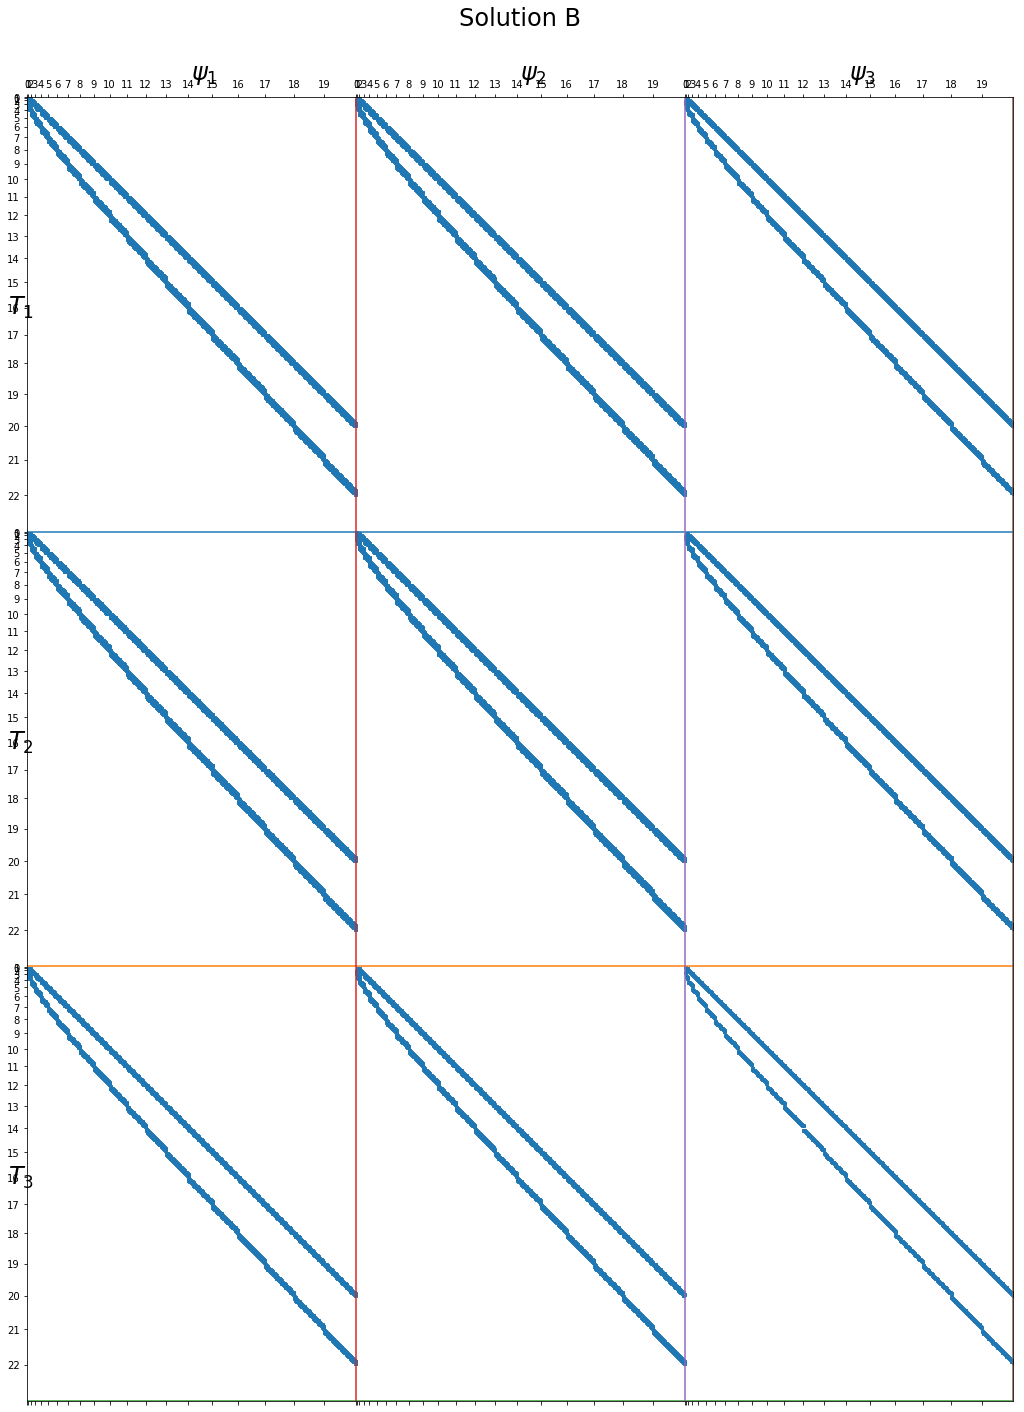

In [12]:
#print('Rank of the submatrix', np.linalg.matrix_rank(Csub.todense()))
plt.figure(figsize=(24,24))
visualize_Cmat(Csub, precision=1e-8, m_max=m_max)
plt.show()

In [13]:
Csub_copy = spm.lil_matrix(Csub.shape, dtype=np.complex)
etol = 1e-8
real_idx = np.abs(np.real(Csub)) > etol
imag_idx = np.abs(np.imag(Csub)) > etol
Csub_copy[real_idx] = Csub[real_idx]
Csub_copy[imag_idx] = Csub[imag_idx]
#print(real_idx.shape, imag_idx.shape)
Csub = Csub_copy
print(Csub.shape)

(1587, 1200)


In [14]:
import time
tic = time.time()
A = spm.linalg.lsqr(Csub, T_usr_vec.transpose())
toc = time.time()
print('Residual:', A[3], 'Time:', toc-tic)
A_sol = A[0]
print('Solution:', A_sol.size)
index_sol = print_SH_mode(A_sol, m_dir=3)

Residual: 0.010635045263984075 Time: 1.1367526054382324
Solution: 1200
index: 5 (2, -1, 0) coeff: (3.24537203981e-18-0.00882622376728j)
index: 7 (2, 1, 0) coeff: (-1.35314864083e-18-0.00882622376728j)
index: 10 (3, -2, 0) coeff: (-4.82233336636e-15-0.00010206188294j)
index: 14 (3, 2, 0) coeff: (5.0045447643e-15+0.000102061885141j)
index: 17 (4, -3, 0) coeff: (-2.61078667017e-16+0.000669184431517j)
index: 19 (4, -1, 0) coeff: (2.09897477346e-13-0.00135124262728j)
index: 21 (4, 1, 0) coeff: (-2.07329453028e-13-0.00135124262857j)
index: 23 (4, 3, 0) coeff: (-5.14932486749e-16+0.000669184431121j)
index: 26 (5, -4, 0) coeff: (-1.4235255748e-18-0.000659847824691j)
index: 28 (5, -2, 0) coeff: (7.62266027326e-18+0.00073471046486j)
index: 32 (5, 2, 0) coeff: (1.14539987641e-17-0.00073471046486j)
index: 34 (5, 4, 0) coeff: (1.31703123851e-18+0.000659847824691j)
index: 37 (6, -5, 0) coeff: (-4.23187531449e-16+0.000553828899794j)
index: 39 (6, -3, 0) coeff: (2.36869639926e-16-0.00042952544905j)
in

Then we integrate the stress solution:

In [15]:
X, Y, Z = np.meshgrid([t, ], [0,], x3)
#print(ts, zs)
sigma_tot = stress_solution(index_sol, X, Y, Z, MU=mu, NU=nu, lmax=lmax_sub, recalc=False)

the stress solution includes: 
l m k coeff
2 -1 0 (3.24537203981e-18-0.00882622376728j)
2 1 0 (-1.35314864083e-18-0.00882622376728j)
3 -2 0 (-4.82233336636e-15-0.00010206188294j)
3 2 0 (5.0045447643e-15+0.000102061885141j)
4 -3 0 (-2.61078667017e-16+0.000669184431517j)
4 -1 0 (2.09897477346e-13-0.00135124262728j)
4 1 0 (-2.07329453028e-13-0.00135124262857j)
4 3 0 (-5.14932486749e-16+0.000669184431121j)
5 -4 0 (-1.4235255748e-18-0.000659847824691j)
5 -2 0 (7.62266027326e-18+0.00073471046486j)
5 2 0 (1.14539987641e-17-0.00073471046486j)
5 4 0 (1.31703123851e-18+0.000659847824691j)
6 -5 0 (-4.23187531449e-16+0.000553828899794j)
6 -3 0 (2.36869639926e-16-0.00042952544905j)
6 3 0 (4.59192521189e-15-0.000429525449146j)
6 5 0 (7.75339873097e-16+0.000553828898977j)
7 -6 0 (7.34662374627e-19-0.00044616586965j)
7 -4 0 (1.02960498916e-18+0.000265794288376j)
7 4 0 (4.80914856987e-19-0.000265794288376j)
7 6 0 (-4.84609302358e-20+0.00044616586965j)
8 -7 0 (-2.22006020994e-19+0.000355623258288j)
8 -5

6 -6 2 (-1.9778496871e-18+0.00267123470665j)
6 -4 2 (3.61317867083e-16-0.00156829866255j)
6 -2 2 (-1.84081700811e-16-3.7567652379e-08j)
6 2 2 (6.37017032715e-15+3.75672693963e-08j)
6 4 2 (6.6213417333e-16+0.00156829866186j)
6 6 2 (-2.07273273899e-18-0.00267123470665j)
7 -7 2 (1.69892863762e-18-0.00201950684517j)
7 -5 2 (-4.52304082616e-19+0.00106306289337j)
7 -3 2 (3.57673897437e-18+4.82136772797e-08j)
7 -1 2 (1.88668685674e-18-1.53916142947e-08j)
7 1 2 (-5.80464405274e-19-1.53916142952e-08j)
7 3 2 (-1.91470910899e-18+4.8213677289e-08j)
7 5 2 (4.11699560452e-19+0.00106306289337j)
7 7 2 (-1.8867169775e-18-0.00201950684517j)
8 -8 2 (-1.42647542846e-18+0.00156093164286j)
8 -6 2 (2.9697932548e-19-0.000742723619289j)
8 -4 2 (-1.90780979001e-19-5.59383828551e-08j)
8 -2 2 (-1.92920544457e-18+2.60699354406e-08j)
8 2 2 (5.19063904731e-18-2.60699354587e-08j)
8 4 2 (5.170730667e-19+5.59383828417e-08j)
8 6 2 (4.39527362565e-19+0.000742723619289j)
8 8 2 (-1.42895477796e-18-0.00156093164286j)
9 -9 2

(1, 1, 30)


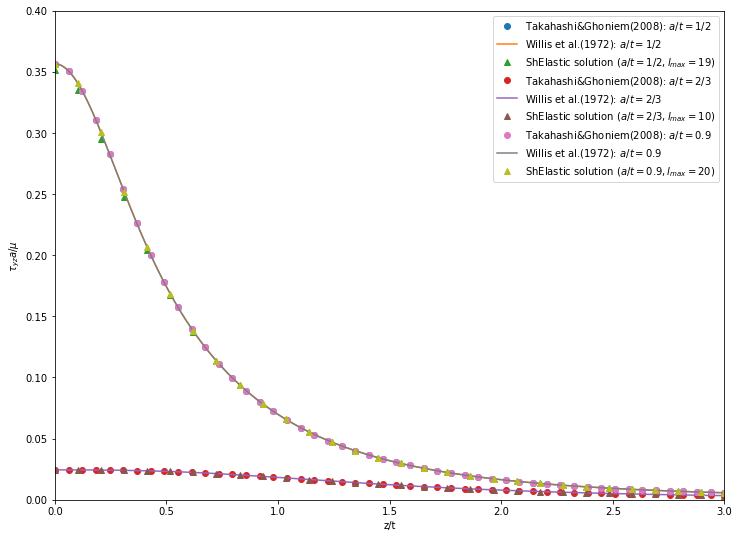

In [16]:
# plot for Willis (1972)
print(sigma_tot[:,:,:,1,2].shape)
plt.figure(figsize=(12, 9))
tau_ShE = np.real(sigma_tot[:,:,:,1,2]).flatten()
#plt.plot(x3, -F_mode36, 'x')
#plt.plot(x3, -F_mode26, 'x')
#plt.plot(x3, -F_mode16, '*')
x3zT= np.linspace(0, 3, 50)
x3z = np.linspace(0, 3, 500)
tau_yz = void_screw_disl(50, x3zT, [t, ], mu, 0, nu, nu, a, b)
F1, Fa, F = willis1972(a, t, 50, x3z)
plt.plot(x3zT, -tau_yz, 'o')
plt.plot(x3z, np.sum(F1[:, :], axis=1))
plt.plot(x3, -tau_ShE.flatten(), '^')
tau_yz = void_screw_disl(50, x3zT, [1.5, ], mu, 0, nu, nu, a, b)
tau_ShE = void_screw_disl(50, x3, [1.5, ], mu, 0, nu, nu, a, b)
F1, Fa, F = willis1972(a, 1.5, 50, x3z)
plt.plot(x3zT, -tau_yz, 'o')
plt.plot(x3z, np.sum(F1[:, :], axis=1))
plt.plot(x3, -tau_ShE, '^')
tau_yz = void_screw_disl(50, x3zT, [1/0.9, ], mu, 0, nu, nu, a, b)
tau_ShE = void_screw_disl(50, x3, [1/0.9, ], mu, 0, nu, nu, a, b)
F1, Fa, F = willis1972(a, 1/0.9, 50, x3z)
plt.plot(x3zT, -tau_yz, 'o')
plt.plot(x3z, np.sum(F1[:, :], axis=1))
plt.plot(x3, -tau_ShE, '^')
plt.legend(['Takahashi&Ghoniem(2008): $a/t=1/2$', \
            'Willis et al.(1972): $a/t=1/2$', \
            'ShElastic solution ($a/t=1/2,l_{max}='+str(mode_sub)+'$)', \
            'Takahashi&Ghoniem(2008): $a/t=2/3$', \
            'Willis et al.(1972): $a/t=2/3$', \
            'ShElastic solution ($a/t=2/3,l_{max}=10$)', \
            'Takahashi&Ghoniem(2008): $a/t=0.9$', \
            'Willis et al.(1972): $a/t=0.9$', \
            'ShElastic solution ($a/t=0.9,l_{max}=20$)'])

plt.xlabel('z/t')
plt.ylabel(r'$\tau_{yz}a/\mu$')
plt.xlim(0, 3)
plt.ylim(0, 0.4)
#plt.legend(['ShElastic solution ($a/d=0.9,l_{max}=26$)', 'ShElastic solution ($l_{max}=16$)', 'ShElastic solution ($l_{max}=6$)', 'Willis(1972)'])
plt.show()